In [ ]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
pcd = o3d.io.read_point_cloud("fragment_000.ply")
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])

PointCloud with 190798 points.
[[ 2.26171875 -0.09253075  1.47265625]
 [ 2.25390625 -0.09085231  1.47265625]
 [ 2.26171875 -0.09179753  1.48046875]
 ...
 [ 0.12109375  0.40638293  1.48828125]
 [ 0.12109375  0.40615749  1.49609375]
 [ 0.12780817  0.38671875  1.49609375]]


In [ ]:
print("Original point cloud has", len(pcd.points), "points")


Original point cloud has 190798 points


DownSample

In [ ]:
import open3d as o3d

print("Downsample the point cloud with a voxel of 0.001")
downpcd = pcd.voxel_down_sample(voxel_size=0.05)

o3d.visualization.draw_geometries(
    [downpcd],
    zoom=0.8,
    front=[0.4257, -0.2125, -0.8795],
    lookat=[2.6172, 2.0475, 1.532],
    up=[-0.0694, -0.9768, 0.2024]
)


Downsample the point cloud with a voxel of 0.001


Vertex Normal Extimation

In [ ]:
print("Recompute the normal of the downsampled point cloud")

downpcd.estimate_normals(
    search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30)
)

o3d.visualization.draw_geometries(
    [downpcd],
    # zoom=0.3412,
    # front=[0.4257, -0.2125, -0.8795],
    # lookat=[2.6172, 2.0475, 1.532],
    # up=[-0.0694, -0.9768, 0.2024],
    point_show_normal=True
)


Recompute the normal of the downsampled point cloud


Point Cloud Outlier Removal

In [ ]:
import open3d as o3d

print("Load a ply point cloud, print it, and render it")
pcd = o3d.io.read_point_cloud("fragment_000.ply")
o3d.visualization.draw_geometries([pcd])

print("Downsample the point cloud with a voxel of 0.02")
voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_down_pcd])


Load a ply point cloud, print it, and render it
Downsample the point cloud with a voxel of 0.02


In [ ]:
#downsample
print("Every 5th points are selected")
uni_down_sample = pcd.uniform_down_sample(every_k_points = 9)
o3d.visualization.draw_geometries([uni_down_sample])

Every 5th points are selected


In [ ]:
import open3d as o3d

def display_inlier_outlier_controlled(cloud, ind, zoom=0.5):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])

    # More reasonable viewing parameters for better control
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                    zoom=zoom,
                                    window_name="Outlier Detection Results")

    return inlier_cloud, outlier_cloud

# Statistical outlier removal
print("Statistical outlier removal")
cl, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=1.0)

# Display with better zoom control
inliers, outliers = display_inlier_outlier_controlled(voxel_down_pcd, ind, zoom=0.8)

# Show just the cleaned point cloud
print("Displaying cleaned point cloud")
o3d.visualization.draw_geometries([cl],
                                window_name="Cleaned Point Cloud",
                                zoom=0.8)

# Print statistics
print(f"Original points: {len(voxel_down_pcd.points)}")
print(f"Inlier points: {len(cl.points)}")
print(f"Outlier points: {len(outliers.points)}")
print(f"Outliers removed: {len(outliers.points)/len(voxel_down_pcd.points)*100:.2f}%")

# Return the cleaned point cloud for further use
cleaned_pcd = cl

Statistical outlier removal
Showing outliers (red) and inliers (gray): 
Displaying cleaned point cloud
Original points: 5027
Inlier points: 4556
Outlier points: 471
Outliers removed: 9.37%


In [ ]:
# Radius outlier removal
print("Radius outlier removal")
cl, ind = voxel_down_pcd.remove_radius_outlier(nb_points=15, radius=0.12)

# Display with better zoom control
inliers, outliers = display_inlier_outlier_controlled(voxel_down_pcd, ind, zoom=0.8)


Radius outlier removal
Showing outliers (red) and inliers (gray): 


From depth maps to point clouds

In [ ]:
import open3d as o3d
import cv2
import numpy as np

print("Read own dataset")

# Read with OpenCV
color_cv = cv2.imread("outdoor_image_1.png")  # BGR format
depth_cv = cv2.imread("outdoor_depth_1.png", cv2.IMREAD_UNCHANGED)  # Should be single-channel

# Resize color image to match depth image size
depth_h, depth_w = depth_cv.shape[:2]
color_resized = cv2.resize(color_cv, (depth_w, depth_h))

# Convert from OpenCV (numpy array) to Open3D image
color_o3d = o3d.geometry.Image(cv2.cvtColor(color_resized, cv2.COLOR_BGR2RGB))
depth_o3d = o3d.geometry.Image(depth_cv)

# Create RGBD image
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_o3d, depth_o3d
)

# Print the RGBD image
print(rgbd_image)


Read own dataset
RGBDImage of size 
Color image : 350x518, with 1 channels.
Depth image : 350x518, with 1 channels.
Use numpy.asarray to access buffer data.


In [ ]:
import open3d as o3d

print("Read Redwood dataset")

# Read the color image (JPEG format)
color_raw = o3d.io.read_image("00000_image.jpg")

# Read the depth image (PNG format)
depth_raw = o3d.io.read_image("00000_depth.png")

# Create an RGBD image from the color and depth images
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw
)

# Print the RGBD image info
print(rgbd_image)

Read Redwood dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


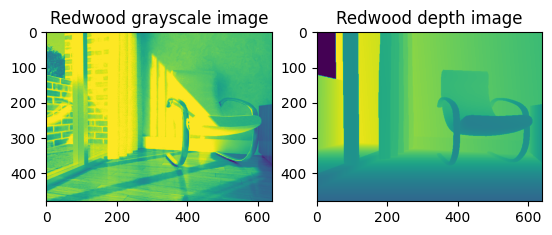

In [ ]:
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np

# Display RGBD images
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(np.asarray(rgbd_image.color))  # Convert Open3D image to numpy array

plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(np.asarray(rgbd_image.depth))  # Convert Open3D image to numpy array

plt.show()


In [ ]:
### RGBD image to pcd using camera parameters
import open3d as o3d

# Create point cloud from RGBD image
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], zoom=0.5)

Transform Depth Maps into Stunning Point Clouds

In [ ]:
import open3d as o3d

print("Read own dataset")

# Read the color image (JPEG format)
color_raw = o3d.io.read_image("image_20250626_015447_001.jpg")

# Read the depth image (PNG format)
depth_raw = o3d.io.read_image("depth_20250626_015447_001.jpg")

# Create an RGBD image from the color and depth images
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw
)

# Print the RGBD image info
print(rgbd_image)

Read own dataset
RGBDImage of size 
Color image : 640x480, with 1 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


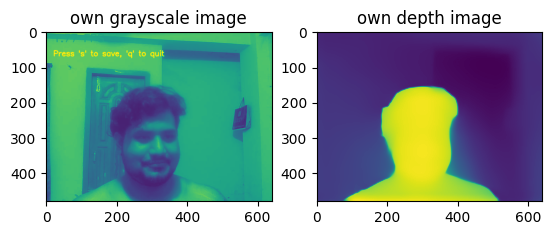

In [ ]:
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np

# Display RGBD images
plt.subplot(1, 2, 1)
plt.title('own grayscale image')
plt.imshow(np.asarray(rgbd_image.color))  # Convert Open3D image to numpy array

plt.subplot(1, 2, 2)
plt.title('own depth image')
plt.imshow(np.asarray(rgbd_image.depth))  # Convert Open3D image to numpy array

plt.show()


In [ ]:
### RGBD image to pcd using camera parameters
import open3d as o3d

# Create point cloud from RGBD image
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Visualize the point cloud
o3d.visualization.draw_geometries([pcd], zoom=0.5)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The reques

In [ ]:
# with own camera intrinsic parameters
import cv2
import numpy as np

# Camera intrinsic parameters from camera used to get color and depth images - Camera Calibration
# Load the camera intrinsic matrix from the .npy file
camera_intrinsic = np.load('intrinsic.npy')
print("Camera Intrinsic Matrix:")
print(camera_intrinsic)

# Set the intrinsic camera parameters
camera_intrinsic_o3d = o3d.camera.PinholeCameraIntrinsic(
    width=640,
    height=480,
    fx=camera_intrinsic[0][0],  # focal length x
    fy=camera_intrinsic[1][1],  # focal length y
    cx=camera_intrinsic[0][2],  # principal point x
    cy=camera_intrinsic[1][2]   # principal point y
)

print("Open3D Camera Intrinsic Parameters:")
print(camera_intrinsic_o3d.intrinsic_matrix)

Camera Intrinsic Matrix:
[[1.32332201e+03 0.00000000e+00 4.69764812e+02]
 [0.00000000e+00 1.40944409e+03 6.49501425e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Open3D Camera Intrinsic Parameters:
[[1.32332201e+03 0.00000000e+00 4.69764812e+02]
 [0.00000000e+00 1.40944409e+03 6.49501425e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
# Create the point cloud from images and camera intrinsic parameters
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic_o3d)

# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd], zoom=0.5)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


ICP Registration

In [ ]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                    )

In [ ]:
import open3d as o3d
import numpy as np

# Load point clouds from PCD files
source = o3d.io.read_point_cloud("fragment_000.ply")
target = o3d.io.read_point_cloud("fragment_001.ply")

# Set registration threshold
threshold = 0.02

# Define initial transformation matrix (4x4 homogeneous transformation)
trans_init = np.asarray([[0.862, 0.011, -0.507, 0.5],
                        [-0.139, 0.967, -0.215, 0.7],
                        [0.487, 0.255, 0.835, -1.4],
                        [0.0, 0.0, 0.0, 1.0]])

# Visualize the registration result
draw_registration_result(source, target, trans_init)

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [ ]:
#because we ta
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.


In [ ]:
#improve matching
import open3d as o3d
import numpy as np
import copy
import sys

def preprocess_point_cloud(pcd, voxel_size):
    """Preprocess point cloud for better registration"""
    print(f":: Preprocessing with voxel size {voxel_size:.3f}")

    # Downsample with voxel grid
    pcd_down = pcd.voxel_down_sample(voxel_size)

    # Estimate normals
    radius_normal = voxel_size * 2
    print(f":: Estimate normal with search radius {radius_normal:.3f}")
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    # Remove statistical outliers
    pcd_clean, _ = pcd_down.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

    return pcd_clean

def compute_fpfh_feature(pcd, voxel_size):
    """Compute FPFH features for point cloud"""
    radius_feature = voxel_size * 5
    print(f":: Compute FPFH feature with search radius {radius_feature:.3f}")
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_fpfh

def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
    """Execute global registration using RANSAC"""
    distance_threshold = voxel_size * 1.5
    print(f":: RANSAC registration on downsampled point clouds")
    print(f"   Since the downsampling voxel size is {voxel_size:.3f},")
    print(f"   we use a liberal distance threshold {distance_threshold:.3f}")

    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))

    return result

def refine_registration(source, target, result_ransac, voxel_size):
    """Refine registration using Point-to-Plane ICP"""
    distance_threshold = voxel_size * 0.4
    print(f":: Point-to-plane ICP registration is applied on original point")
    print(f"   clouds to refine the alignment. This time we use a strict")
    print(f"   distance threshold {distance_threshold:.3f}")

    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())

    return result

def draw_registration_result_safe(source, target, transformation, window_name="Registration Result"):
    """Safely visualize registration result with proper error handling"""
    try:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
        source_temp.transform(transformation)

        # Method 1: Simple visualization (recommended)
        print(f":: Showing {window_name}. Close window to continue...")
        o3d.visualization.draw_geometries([source_temp, target_temp],
                                        window_name=window_name,
                                        width=800, height=600)

    except Exception as e:
        print(f"Visualization error: {e}")
        print("Continuing without visualization...")

def draw_registration_result_non_blocking(source, target, transformation, window_name="Registration Result"):
    """Non-blocking visualization using visualizer class"""
    try:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
        source_temp.transform(transformation)

        # Create visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window(window_name=window_name, width=800, height=600)

        # Add geometries
        vis.add_geometry(source_temp)
        vis.add_geometry(target_temp)

        # Set view control
        ctr = vis.get_view_control()
        ctr.set_zoom(0.4459)
        ctr.set_front([0.9288, -0.2951, -0.2242])
        ctr.set_lookat([1.6784, 2.0612, 1.4451])
        ctr.set_up([-0.3402, -0.9189, -0.1996])

        print(f":: Showing {window_name}. Close window to continue...")

        # Run visualizer
        vis.run()
        vis.destroy_window()

    except Exception as e:
        print(f"Visualization error: {e}")
        print("Continuing without visualization...")

def save_registration_result(source, target, transformation, filename_prefix="registration_result"):
    """Save registration result to files instead of/in addition to visualization"""
    try:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
        source_temp.transform(transformation)

        # Save individual point clouds
        o3d.io.write_point_cloud(f"{filename_prefix}_source_aligned.ply", source_temp)
        o3d.io.write_point_cloud(f"{filename_prefix}_target.ply", target_temp)

        # Save combined point cloud
        combined = source_temp + target_temp
        o3d.io.write_point_cloud(f"{filename_prefix}_combined.ply", combined)

        print(f":: Saved registration result to {filename_prefix}_*.ply files")

    except Exception as e:
        print(f"Save error: {e}")

def evaluate_registration(source, target, transformation, threshold):
    """Evaluate registration quality"""
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)

    evaluation = o3d.pipelines.registration.evaluate_registration(
        source_temp, target, threshold)

    return evaluation

# Main registration pipeline with improved error handling
def improved_point_cloud_registration(enable_visualization=True, save_results=True):
    """Complete improved point cloud registration pipeline"""

    try:
        # Load point clouds
        print(":: Loading point clouds...")
        source = o3d.io.read_point_cloud("fragment_000.ply")
        target = o3d.io.read_point_cloud("fragment_001.ply")

        # Check if point clouds loaded successfully
        if len(source.points) == 0 or len(target.points) == 0:
            print("Error: Could not load point clouds. Check file paths.")
            return None

        print(f"Source: {len(source.points)} points")
        print(f"Target: {len(target.points)} points")

        # Visualize original point clouds
        if enable_visualization:
            print(":: Visualizing original point clouds...")
            draw_registration_result_safe(source, target, np.identity(4), "Original Point Clouds")

        # Set voxel size (adjust based on your data scale)
        voxel_size = 0.05  # Adjust this value based on your point cloud scale

        # Preprocess point clouds
        print(":: Preprocessing point clouds...")
        source_down = preprocess_point_cloud(source, voxel_size)
        target_down = preprocess_point_cloud(target, voxel_size)

        print(f"Source downsampled: {len(source_down.points)} points")
        print(f"Target downsampled: {len(target_down.points)} points")

        # Compute features
        print(":: Computing FPFH features...")
        source_fpfh = compute_fpfh_feature(source_down, voxel_size)
        target_fpfh = compute_fpfh_feature(target_down, voxel_size)

        # Global registration
        print(":: Executing global registration...")
        result_ransac = execute_global_registration(source_down, target_down,
                                                  source_fpfh, target_fpfh, voxel_size)

        # Evaluate global registration
        evaluation = evaluate_registration(source, target, result_ransac.transformation, voxel_size)
        print(f"Global registration - Fitness: {evaluation.fitness:.4f}, RMSE: {evaluation.inlier_rmse:.4f}")

        # Visualize global registration result
        if enable_visualization:
            print(":: Visualizing global registration result...")
            draw_registration_result_safe(source, target, result_ransac.transformation, "Global Registration")

        # Refine with ICP
        print(":: Refining registration with ICP...")
        result_icp = refine_registration(source, target, result_ransac, voxel_size)

        # Evaluate refined registration
        evaluation_icp = evaluate_registration(source, target, result_icp.transformation, voxel_size * 0.4)
        print(f"ICP registration - Fitness: {evaluation_icp.fitness:.4f}, RMSE: {evaluation_icp.inlier_rmse:.4f}")

        # Visualize final result
        if enable_visualization:
            print(":: Visualizing final registration result...")
            draw_registration_result_safe(source, target, result_icp.transformation, "Final Registration")

        # Save results
        if save_results:
            save_registration_result(source, target, result_icp.transformation, "final_registration")

        # Print transformation matrix
        print(":: Final transformation matrix:")
        print(result_icp.transformation)

        return result_icp

    except KeyboardInterrupt:
        print("\n:: Registration interrupted by user")
        return None
    except Exception as e:
        print(f"Error during registration: {e}")
        import traceback
        traceback.print_exc()
        return None



# Run the improved registration
if __name__ == "__main__":
    print("=== Improved Point Cloud Registration ===")
    print("Choose registration method:")
    print("1. Full pipeline with visualization")
    print("2. Full pipeline without visualization")


    try:
        choice = input("Enter choice (1-3): ").strip()

        if choice == "1":
            result = improved_point_cloud_registration(enable_visualization=True, save_results=True)
        elif choice == "2":
            result = improved_point_cloud_registration(enable_visualization=False, save_results=True)

        else:
            print("Running full pipeline with visualization (default)")
            result = improved_point_cloud_registration(enable_visualization=True, save_results=True)

        if result is not None:
            print(":: Registration completed successfully!")
        else:
            print(":: Registration failed or was interrupted")

    except KeyboardInterrupt:
        print("\n:: Program interrupted by user")
        sys.exit(0)
    except Exception as e:
        print(f":: Unexpected error: {e}")
        sys.exit(1)

=== Improved Point Cloud Registration ===
Choose registration method:
1. Full pipeline with visualization
2. Full pipeline without visualization
3. Quick registration without visualization
:: Loading point clouds...
Source: 190798 points
Target: 207752 points
:: Visualizing original point clouds...
:: Showing Original Point Clouds. Close window to continue...
:: Preprocessing point clouds...
:: Preprocessing with voxel size 0.050
:: Estimate normal with search radius 0.100
:: Preprocessing with voxel size 0.050
:: Estimate normal with search radius 0.100
Source downsampled: 4856 points
Target downsampled: 5183 points
:: Computing FPFH features...
:: Compute FPFH feature with search radius 0.250
:: Compute FPFH feature with search radius 0.250
:: Executing global registration...
:: RANSAC registration on downsampled point clouds
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075
Global registration - Fitness: 0.7623, RMSE: 0.0208
:: Visualizing g

Traceback (most recent call last):
  File "C:\Users\indroneel\AppData\Local\Temp\ipykernel_15164\1793258712.py", line 203, in improved_point_cloud_registration
    result_icp = refine_registration(source, target, result_ransac, voxel_size)
  File "C:\Users\indroneel\AppData\Local\Temp\ipykernel_15164\1793258712.py", line 57, in refine_registration
    result = o3d.pipelines.registration.registration_icp(
RuntimeError: [Open3D Error] (class std::tuple<class std::shared_ptr<class open3d::geometry::PointCloud const >,class std::shared_ptr<class open3d::geometry::PointCloud const > > __cdecl open3d::pipelines::registration::TransformationEstimationPointToPlane::InitializePointCloudsForTransformation(const class open3d::geometry::PointCloud &,const class open3d::geometry::PointCloud &,double) const) D:\a\Open3D\Open3D\cpp\open3d\pipelines\registration\TransformationEstimation.cpp:120: PointToPlaneICP requires target pointcloud to have normals.



In [ ]:
# Point cloud registration using ICP algorithm
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint(),
    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

print(reg_p2p)
print("Transformation is:")
print(reg_p2p.transformation)
draw_registration_result(source, target, reg_p2p.transformation)

RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.862  0.011 -0.507  0.5  ]
 [-0.139  0.967 -0.215  0.7  ]
 [ 0.487  0.255  0.835 -1.4  ]
 [ 0.     0.     0.     1.   ]]
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


Include point2point ICP

In [ ]:
#improve matching
import open3d as o3d
import numpy as np
import copy
import sys

def preprocess_point_cloud(pcd, voxel_size):
    """Preprocess point cloud for better registration"""
    print(f":: Preprocessing with voxel size {voxel_size:.3f}")

    # Downsample with voxel grid
    pcd_down = pcd.voxel_down_sample(voxel_size)

    # Estimate normals
    radius_normal = voxel_size * 2
    print(f":: Estimate normal with search radius {radius_normal:.3f}")
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    # Remove statistical outliers
    pcd_clean, _ = pcd_down.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

    return pcd_clean

def compute_fpfh_feature(pcd, voxel_size):
    """Compute FPFH features for point cloud"""
    radius_feature = voxel_size * 5
    print(f":: Compute FPFH feature with search radius {radius_feature:.3f}")
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_fpfh

def execute_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size):
    """Execute global registration using RANSAC"""
    distance_threshold = voxel_size * 1.5
    print(f":: RANSAC registration on downsampled point clouds")
    print(f"   Since the downsampling voxel size is {voxel_size:.3f},")
    print(f"   we use a liberal distance threshold {distance_threshold:.3f}")

    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))

    return result

def refine_registration(source, target, result_ransac, voxel_size):
    """Refine registration using Point-to-Plane ICP"""
    distance_threshold = voxel_size * 0.4
    print(f":: Point-to-plane ICP registration is applied on original point")
    print(f"   clouds to refine the alignment. This time we use a strict")
    print(f"   distance threshold {distance_threshold:.3f}")

    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())

    return result

def icp_point_to_point_registration(source, target, threshold, trans_init):
    """Point-to-Point ICP registration with your specific parameters"""
    print(f":: Point-to-Point ICP registration with threshold {threshold:.3f}")

    reg_p2p = o3d.pipelines.registration.registration_icp(
        source, target, threshold, trans_init,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

    print(reg_p2p)
    print("Transformation is:")
    print(reg_p2p.transformation)

    return reg_p2p

def draw_registration_result(source, target, transformation):
    """Original draw_registration_result function"""
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
    target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp])

def draw_registration_result_safe(source, target, transformation, window_name="Registration Result"):
    """Safely visualize registration result with proper error handling"""
    try:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
        source_temp.transform(transformation)

        # Method 1: Simple visualization (recommended)
        print(f":: Showing {window_name}. Close window to continue...")
        o3d.visualization.draw_geometries([source_temp, target_temp],
                                        window_name=window_name,
                                        width=800, height=600)

    except Exception as e:
        print(f"Visualization error: {e}")
        print("Continuing without visualization...")

def draw_registration_result_non_blocking(source, target, transformation, window_name="Registration Result"):
    """Non-blocking visualization using visualizer class"""
    try:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
        source_temp.transform(transformation)

        # Create visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window(window_name=window_name, width=800, height=600)

        # Add geometries
        vis.add_geometry(source_temp)
        vis.add_geometry(target_temp)

        # Set view control
        ctr = vis.get_view_control()
        ctr.set_zoom(0.4459)
        ctr.set_front([0.9288, -0.2951, -0.2242])
        ctr.set_lookat([1.6784, 2.0612, 1.4451])
        ctr.set_up([-0.3402, -0.9189, -0.1996])

        print(f":: Showing {window_name}. Close window to continue...")

        # Run visualizer
        vis.run()
        vis.destroy_window()

    except Exception as e:
        print(f"Visualization error: {e}")
        print("Continuing without visualization...")

def save_registration_result(source, target, transformation, filename_prefix="registration_result"):
    """Save registration result to files instead of/in addition to visualization"""
    try:
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])  # Orange
        target_temp.paint_uniform_color([0, 0.651, 0.929])  # Blue
        source_temp.transform(transformation)

        # Save individual point clouds
        o3d.io.write_point_cloud(f"{filename_prefix}_source_aligned.ply", source_temp)
        o3d.io.write_point_cloud(f"{filename_prefix}_target.ply", target_temp)

        # Save combined point cloud
        combined = source_temp + target_temp
        o3d.io.write_point_cloud(f"{filename_prefix}_combined.ply", combined)

        print(f":: Saved registration result to {filename_prefix}_*.ply files")

    except Exception as e:
        print(f"Save error: {e}")

def evaluate_registration(source, target, transformation, threshold):
    """Evaluate registration quality"""
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)

    evaluation = o3d.pipelines.registration.evaluate_registration(
        source_temp, target, threshold)

    return evaluation

# Main registration pipeline with improved error handling
def improved_point_cloud_registration(enable_visualization=True, save_results=True):
    """Complete improved point cloud registration pipeline"""

    try:
        # Load point clouds
        print(":: Loading point clouds...")
        source = o3d.io.read_point_cloud("fragment_000.ply")
        target = o3d.io.read_point_cloud("fragment_001.ply")

        # Check if point clouds loaded successfully
        if len(source.points) == 0 or len(target.points) == 0:
            print("Error: Could not load point clouds. Check file paths.")
            return None

        print(f"Source: {len(source.points)} points")
        print(f"Target: {len(target.points)} points")

        # Visualize original point clouds
        if enable_visualization:
            print(":: Visualizing original point clouds...")
            draw_registration_result_safe(source, target, np.identity(4), "Original Point Clouds")

        # Set voxel size (adjust based on your data scale)
        voxel_size = 0.05  # Adjust this value based on your point cloud scale

        # Preprocess point clouds
        print(":: Preprocessing point clouds...")
        source_down = preprocess_point_cloud(source, voxel_size)
        target_down = preprocess_point_cloud(target, voxel_size)

        print(f"Source downsampled: {len(source_down.points)} points")
        print(f"Target downsampled: {len(target_down.points)} points")

        # Compute features
        print(":: Computing FPFH features...")
        source_fpfh = compute_fpfh_feature(source_down, voxel_size)
        target_fpfh = compute_fpfh_feature(target_down, voxel_size)

        # Global registration
        print(":: Executing global registration...")
        result_ransac = execute_global_registration(source_down, target_down,
                                                  source_fpfh, target_fpfh, voxel_size)

        # Evaluate global registration
        evaluation = evaluate_registration(source, target, result_ransac.transformation, voxel_size)
        print(f"Global registration - Fitness: {evaluation.fitness:.4f}, RMSE: {evaluation.inlier_rmse:.4f}")

        # Visualize global registration result
        if enable_visualization:
            print(":: Visualizing global registration result...")
            draw_registration_result_safe(source, target, result_ransac.transformation, "Global Registration")

        # Your specific Point-to-Point ICP registration
        print(":: Executing your Point-to-Point ICP registration...")
        threshold = voxel_size * 0.4
        trans_init = result_ransac.transformation
        reg_p2p = icp_point_to_point_registration(source, target, threshold, trans_init)

        # Visualize your ICP result
        if enable_visualization:
            print(":: Visualizing Point-to-Point ICP result...")
            draw_registration_result(source, target, reg_p2p.transformation)

        # Refine with Point-to-Plane ICP
        print(":: Refining registration with Point-to-Plane ICP...")
        result_icp = refine_registration(source, target, result_ransac, voxel_size)

        # Evaluate refined registration
        evaluation_icp = evaluate_registration(source, target, result_icp.transformation, voxel_size * 0.4)
        print(f"Point-to-Plane ICP registration - Fitness: {evaluation_icp.fitness:.4f}, RMSE: {evaluation_icp.inlier_rmse:.4f}")

        # Visualize final result
        if enable_visualization:
            print(":: Visualizing final registration result...")
            draw_registration_result_safe(source, target, result_icp.transformation, "Final Registration")

        # Save results
        if save_results:
            save_registration_result(source, target, result_icp.transformation, "final_registration")

        # Print transformation matrix
        print(":: Final transformation matrix:")
        print(result_icp.transformation)

        return result_icp

    except KeyboardInterrupt:
        print("\n:: Registration interrupted by user")
        return None
    except Exception as e:
        print(f"Error during registration: {e}")
        import traceback
        traceback.print_exc()
        return None

# Simple function to run just your specific ICP code
def run_simple_icp():
    """Run just the Point-to-Point ICP registration code you provided"""
    try:
        # Load point clouds (you may need to adjust file paths)
        source = o3d.io.read_point_cloud("fragment_000.ply")
        target = o3d.io.read_point_cloud("fragment_001.ply")

        # Set parameters
        threshold = 0.02  # Adjust based on your data
        trans_init = np.identity(4)  # Identity matrix as initial transformation

        # Your specific ICP code
        reg_p2p = o3d.pipelines.registration.registration_icp(
            source, target, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint(),
            o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=2000))

        print(reg_p2p)
        print("Transformation is:")
        print(reg_p2p.transformation)
        draw_registration_result(source, target, reg_p2p.transformation)

        return reg_p2p

    except Exception as e:
        print(f"Error: {e}")
        return None

# Run the improved registration
if __name__ == "__main__":
    print("=== Improved Point Cloud Registration ===")
    print("Choose registration method:")
    print("1. Full pipeline with visualization")
    print("2. Full pipeline without visualization")
    print("3. Simple Point-to-Point ICP only")

    try:
        choice = input("Enter choice (1-3): ").strip()

        if choice == "1":
            result = improved_point_cloud_registration(enable_visualization=True, save_results=True)
        elif choice == "2":
            result = improved_point_cloud_registration(enable_visualization=False, save_results=True)
        elif choice == "3":
            result = run_simple_icp()
        else:
            print("Running full pipeline with visualization (default)")
            result = improved_point_cloud_registration(enable_visualization=True, save_results=True)

        if result is not None:
            print(":: Registration completed successfully!")
        else:
            print(":: Registration failed or was interrupted")

    except KeyboardInterrupt:
        print("\n:: Program interrupted by user")
        sys.exit(0)
    except Exception as e:
        print(f":: Unexpected error: {e}")
        sys.exit(1)

=== Improved Point Cloud Registration ===
Choose registration method:
1. Full pipeline with visualization
2. Full pipeline without visualization
3. Simple Point-to-Point ICP only
:: Loading point clouds...
Source: 190798 points
Target: 207752 points
:: Visualizing original point clouds...
:: Showing Original Point Clouds. Close window to continue...
:: Preprocessing point clouds...
:: Preprocessing with voxel size 0.050
:: Estimate normal with search radius 0.100
:: Preprocessing with voxel size 0.050
:: Estimate normal with search radius 0.100
Source downsampled: 4856 points
Target downsampled: 5183 points
:: Computing FPFH features...
:: Compute FPFH feature with search radius 0.250
:: Compute FPFH feature with search radius 0.250
:: Executing global registration...
:: RANSAC registration on downsampled point clouds
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075
Global registration - Fitness: 0.7513, RMSE: 0.0228
:: Visualizing global regi

Traceback (most recent call last):
  File "C:\Users\indroneel\AppData\Local\Temp\ipykernel_15164\1684333343.py", line 239, in improved_point_cloud_registration
    result_icp = refine_registration(source, target, result_ransac, voxel_size)
  File "C:\Users\indroneel\AppData\Local\Temp\ipykernel_15164\1684333343.py", line 58, in refine_registration
    result = o3d.pipelines.registration.registration_icp(
RuntimeError: [Open3D Error] (class std::tuple<class std::shared_ptr<class open3d::geometry::PointCloud const >,class std::shared_ptr<class open3d::geometry::PointCloud const > > __cdecl open3d::pipelines::registration::TransformationEstimationPointToPlane::InitializePointCloudsForTransformation(const class open3d::geometry::PointCloud &,const class open3d::geometry::PointCloud &,double) const) D:\a\Open3D\Open3D\cpp\open3d\pipelines\registration\TransformationEstimation.cpp:120: PointToPlaneICP requires target pointcloud to have normals.



Global Registration

In [ ]:
import copy
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target_temp],
                                    )

In [ ]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))

    return pcd_down, pcd_fpfh


In [ ]:
def prepare_dataset(voxel_size):
    print(":: Load two point clouds and disturb initial pose.")
    source = o3d.io.read_point_cloud("fragment_000.ply")
    target = o3d.io.read_point_cloud("fragment_001.ply")

    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0],
                             [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0],
                             [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source, target, source_down, target_down, source_fpfh, target_fpfh


In [ ]:
voxel_size = 0.05  # means 5cm for this dataset
source, target, source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(
    voxel_size)


:: Load two point clouds and disturb initial pose.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.
:: Downsample with a voxel size 0.050.
:: Estimate normal with search radius 0.100.
:: Compute FPFH feature with search radius 0.250.


In [ ]:
def execute_global_registration(source_down, target_down, source_fpfh,
                               target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    print(": RANSAC registration on downsampled point clouds.")
    print("   Since the downsampling voxel size is %.3f," % voxel_size)
    print("   we use a liberal distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [ ]:
result_ransac = execute_global_registration(source_down, target_down,
                                          source_fpfh, target_fpfh,
                                          voxel_size)
print(result_ransac)
draw_registration_result(source_down, target_down, result_ransac.transformation)

: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.050,
   we use a liberal distance threshold 0.075.
RegistrationResult with fitness=7.831709e-01, inlier_rmse=2.833077e-02, and correspondence_set size of 3937
Access transformation to get result.
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
